In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests


class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
           
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")

 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

# Train data:
data['observation_value_matrix'] <br />
metadata["observation_ids"]<br />
metadata["observation_timestamps"]<br />
<br />
data['action_value_matrix']<br />
metadata["action_ids"]<br />

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']<br />
metadata_val["action_ids"]<br />
metadata_val["observation_timestamps"]<br />
floorplan
device_layout_map

exogenous_observation_data<br />
exogenous_observation_data_ids<br />
initial_condition

# Predict:
temp_data <br />
temp_data_ids


## Exploratory Data Analysis

In [3]:
data['observation_value_matrix'].shape

(51852, 1198)

In [4]:
data['action_value_matrix'].shape

(51852, 3)

In [5]:
print(data['action_value_matrix'][0], data['action_value_matrix'][3000])

[288.70370483 310.92593384 291.48147583] [290.37036133 352.59259033 291.48147583]


In [6]:
metadata['action_ids']

{'12945159110931775488@supply_air_temperature_setpoint': 0,
 '13761436543392677888@supply_water_temperature_setpoint': 1,
 '14409954889734029312@supply_air_temperature_setpoint': 2}

In [7]:
metadata["observation_ids"]

{'202194278473007104@building_air_static_pressure_setpoint': 0,
 '202194278473007104@building_air_static_pressure_sensor': 1,
 '202194278473007104@outside_air_flowrate_sensor': 2,
 '202194278473007104@exhaust_air_damper_percentage_command': 3,
 '202194278473007104@cooling_percentage_command': 4,
 '202194278473007104@supply_air_temperature_setpoint': 5,
 '202194278473007104@return_air_temperature_sensor': 6,
 '202194278473007104@supply_fan_speed_percentage_command': 7,
 '202194278473007104@supply_fan_speed_frequency_sensor': 8,
 '202194278473007104@mixed_air_temperature_sensor': 9,
 '202194278473007104@supply_air_static_pressure_sensor': 10,
 '202194278473007104@outside_air_flowrate_setpoint': 11,
 '202194278473007104@exhaust_fan_speed_frequency_sensor': 12,
 '202194278473007104@exhaust_fan_speed_percentage_command': 13,
 '202194278473007104@mixed_air_temperature_setpoint': 14,
 '202194278473007104@supply_air_temperature_sensor': 15,
 '202194278473007104@outside_air_damper_percentage_co

In [8]:
initial_condition.shape

(123,)

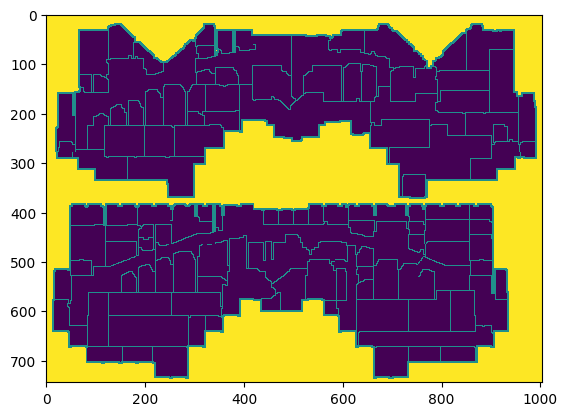

In [9]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [10]:
device_layout_map.keys()

dict_keys(['exterior_space', '1-13', '1-21', '1-46', '1-29', '1-12', '1-20', '1-22', '1-25', '1-28', '1-23', '1-26', '1-15', '1-14', '', '1-17', '1-32', '1-44', '1-43', '1-27', '1-18', '1-16', '1-31', '1-11', '1-10', '1-52', '1-50', '1-19', '1-47', '1-33', '1-09', '1-30', '1-08', '1-07', '1-48', '1-51', '1-34', '1-05', '1-42', '1-53', '1-39', '1-35', '1-04', '1-54', '1-37', '1-03', '1-36', '1-02', '1-55', '1-40', '2-19', '2-20', '2-21', '2-12', '2-22', '2-23', '2-27', '2-28', '2-42', '2-30', '2-31', '2-32', '2-24', '2-25', '2-26', '2-38', '2-33', '2-43', '2-39', '2-16', '2-18', '2-14', '2-40', '2-34', '2-64', '2-13', '2-10', '2-17', '2-37', '2-57', '2-44', '2-5', '2-9', '2-36', '2-8', '2-15', '2-61', '2-46', '2-35', '2-47', '2-7', '2-72', '2-60', '2-48', '2-6', '2-49', '2-65', '2-45', '2-50', '2-4', '2-3', '2-66', '2-59', '2-2', '2-51', '2-58', '2-68', '2-69', '2-67', '2-56', '2-1', '2-71', '2-70', '2-55', '2-54', '2-53', 'unrecognized'])

In [11]:
temp_data.shape

(53292, 123)

## Dataset Configuration for Models


### Extract the Desired Data Fields

In [12]:
data_train, metadata_train = data, metadata

temp_indexes = [v for k, v in metadata_train['observation_ids'].items()
                if "zone_air_temperature_sensor" in k]
temp_data_train = data_train['observation_value_matrix'][:, temp_indexes]
temp_data_train_ids = {
    k: i for i, (k, v) in enumerate(
        [(k, v) for k, v in metadata_train['observation_ids'].items()
         if "zone_air_temperature_sensor" in k]
    )
}

exog_train_indexes = [v for k, v in metadata_train['observation_ids'].items()
                if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_train = data_train['observation_value_matrix'][:, exog_train_indexes]
exogenous_observation_data_train_ids = {
    k: i for i, (k, v) in enumerate(
        [(k, v) for k, v in metadata_train['observation_ids'].items()
         if "zone_air_temperature_sensor" not in k]
    )
}

action_data_train = data_train['action_value_matrix']

### Extract the final month (June, 2022) from the training data

In [13]:
import torch

train_temp = temp_data_train[-8640:]
train_exog = exogenous_observation_data_train[-8640:]
train_actions = action_data_train[-8640:]

initial_condition_tensor = torch.tensor(initial_condition, dtype=torch.float32)
exog_future_tensor = torch.tensor(exogenous_observation_data[:2016], dtype=torch.float32)  # [2016, 1098]
actions_future_tensor = torch.tensor(data_val['action_value_matrix'][:2016], dtype=torch.float32)  # [2016, 3]

print(train_temp.shape)
print(train_exog.shape)
print(train_actions.shape)

(8640, 123)
(8640, 1075)
(8640, 3)


In [14]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from scipy.linalg import solve_discrete_are
import matplotlib.pyplot as plt
from typing import Tuple, Optional


In [35]:
class RobustBuildingKalmanFilter:
    """
    Robust Kalman Filter for building temperature forecasting with numerical stability.
    """
    
    def __init__(self, n_rooms: int, n_inputs: int, state_dim: int = None):
        """
        Initialize the Kalman Filter.
        
        Args:
            n_rooms: Number of temperature sensors (123)
            n_inputs: Number of input variables (exogenous + actions)
            state_dim: Dimension of hidden state (if None, set to n_rooms)
        """
        self.n_rooms = n_rooms
        self.n_inputs = n_inputs
        self.state_dim = state_dim or n_rooms
        
        # System matrices (to be learned)
        self.A = None  # State transition matrix
        self.B = None  # Input matrix
        self.C = None  # Observation matrix
        self.Q = None  # Process noise covariance
        self.R = None  # Observation noise covariance
        
        # Current state estimate
        self.x_hat = None  # State estimate
        self.P = None      # State covariance
        
        # Scalers for preprocessing
        self.temp_scaler = StandardScaler()
        self.input_scaler = StandardScaler()
        
        # Numerical stability parameters
        self.min_eigenval = 1e-6
        self.max_eigenval = 0.99
        self.reg_coeff = 1e-4
        
    def _regularize_matrix(self, matrix: np.ndarray, reg_coeff: float = None) -> np.ndarray:
        """Add regularization to improve numerical stability."""
        if reg_coeff is None:
            reg_coeff = self.reg_coeff
        return matrix + reg_coeff * np.eye(matrix.shape[0])
    
    def _stabilize_transition_matrix(self, A: np.ndarray) -> np.ndarray:
        """Ensure A matrix has eigenvalues < 1 for stability."""
        eigenvals, eigenvecs = np.linalg.eig(A)
        
        # Clip eigenvalues to ensure stability
        eigenvals_clipped = np.where(
            np.abs(eigenvals) > self.max_eigenval,
            self.max_eigenval * np.sign(eigenvals.real),
            eigenvals
        )
        
        # Reconstruct matrix with clipped eigenvalues
        A_stable = eigenvecs @ np.diag(eigenvals_clipped) @ np.linalg.inv(eigenvecs)
        return A_stable.real
    
    def _ensure_positive_definite(self, matrix: np.ndarray) -> np.ndarray:
        """Ensure matrix is positive definite with better conditioning."""
        # Use more aggressive regularization for very ill-conditioned matrices
        eigenvals, eigenvecs = np.linalg.eigh(matrix)
        
        # Set minimum eigenvalue based on condition number
        max_eigenval = np.max(eigenvals)
        min_eigenval = max(self.min_eigenval, max_eigenval / 1000)  # Condition number < 1000
        
        eigenvals_pos = np.maximum(eigenvals, min_eigenval)
        return eigenvecs @ np.diag(eigenvals_pos) @ eigenvecs.T
    
    def learn_dynamics(self, temp_data: np.ndarray, input_data: np.ndarray, 
                      regularization: float = 0.1) -> None:
        """
        Learn system dynamics with improved numerical stability.
        
        Args:
            temp_data: Temperature data [T, n_rooms]
            input_data: Input data [T, n_inputs]
            regularization: Ridge regularization parameter
        """
        print(f"Learning dynamics from {temp_data.shape[0]} timesteps...")
        
        # Normalize data with clipping to prevent extreme values
        temp_clipped = np.clip(temp_data, 
                              np.percentile(temp_data, 1), 
                              np.percentile(temp_data, 99))
        
        input_clipped = np.clip(input_data,
                               np.percentile(input_data, 1, axis=0),
                               np.percentile(input_data, 99, axis=0))
        
        temp_scaled = self.temp_scaler.fit_transform(temp_clipped)
        input_scaled = self.input_scaler.fit_transform(input_clipped)
        
        # Prepare data for system identification
        X = temp_scaled[:-1]  # States at t
        Y = temp_scaled[1:]   # States at t+1
        U = input_scaled[:-1] # Inputs at t
        
        # Use multiple ridge regression with different regularization
        # to find stable solution
        best_residual = float('inf')
        best_A, best_B = None, None
        
        for reg in [regularization * (0.1 ** i) for i in range(4)]:
            try:
                # Create augmented feature matrix
                features = np.hstack([X, U])
                
                # Fit ridge regression
                ridge = Ridge(alpha=reg, fit_intercept=False)
                ridge.fit(features, Y)
                
                # Extract matrices
                A_candidate = ridge.coef_[:, :self.state_dim]
                B_candidate = ridge.coef_[:, self.state_dim:]
                
                # Check stability
                max_eig = np.max(np.abs(np.linalg.eigvals(A_candidate)))
                if max_eig > 1.1:  # Too unstable
                    continue
                
                # Evaluate residual
                Y_pred = ridge.predict(features)
                residual = np.mean((Y - Y_pred) ** 2)
                
                if residual < best_residual and not np.isnan(residual):
                    best_residual = residual
                    best_A, best_B = A_candidate, B_candidate
                    
            except Exception as e:
                print(f"Regularization {reg} failed: {e}")
                continue
        
        if best_A is None:
            raise ValueError("Could not find stable system matrices")
        
        # Stabilize the transition matrix
        self.A = self._stabilize_transition_matrix(best_A)
        self.B = best_B
        self.C = np.eye(self.state_dim)  # Direct observation
        
        # Estimate noise covariances more robustly
        features = np.hstack([X, U])
        ridge_final = Ridge(alpha=regularization, fit_intercept=False)
        ridge_final.fit(features, Y)
        Y_pred = ridge_final.predict(features)
        
        # Process noise covariance
        residuals = Y - Y_pred
        Q_raw = np.cov(residuals.T)
        self.Q = self._ensure_positive_definite(Q_raw)
        
        # Observation noise covariance  
        obs_residuals = temp_scaled[1:] - Y_pred
        R_raw = np.cov(obs_residuals.T)
        self.R = self._ensure_positive_definite(R_raw)
        
        # Additional regularization for very ill-conditioned matrices
        if np.linalg.cond(self.Q) > 1000:
            self.Q = self._regularize_matrix(self.Q, 0.1)
        if np.linalg.cond(self.R) > 1000:
            self.R = self._regularize_matrix(self.R, 0.1)
        
        # Verify system stability
        max_eigenval = np.max(np.abs(np.linalg.eigvals(self.A)))
        q_cond = np.linalg.cond(self.Q)
        r_cond = np.linalg.cond(self.R)
        
        print(f"System matrices learned successfully:")
        print(f"A matrix shape: {self.A.shape}")
        print(f"B matrix shape: {self.B.shape}")
        print(f"Max eigenvalue: {max_eigenval:.4f} (stable: {max_eigenval < 1})")
        print(f"Q matrix condition number: {q_cond:.2f}")
        print(f"R matrix condition number: {r_cond:.2f}")
        print(f"Training MSE: {best_residual:.6f}")
        
    def initialize_filter(self, initial_temp: np.ndarray) -> None:
        """Initialize the Kalman filter with initial conditions."""
        # Clip initial temperature to reasonable range
        initial_clipped = np.clip(initial_temp, 
                                 np.percentile(initial_temp, 5),
                                 np.percentile(initial_temp, 95))
        
        # Scale initial temperature
        initial_scaled = self.temp_scaler.transform(initial_clipped.reshape(1, -1)).flatten()
        
        # Check for NaN values
        if np.any(np.isnan(initial_scaled)) or np.any(np.isinf(initial_scaled)):
            print("Warning: NaN/Inf in initial conditions, using zero initialization")
            initial_scaled = np.zeros(self.state_dim)
        
        # Initialize state estimate
        self.x_hat = initial_scaled.copy()
        
        # Initialize state covariance with smaller values
        self.P = np.eye(self.state_dim) * 0.01
        
    def predict(self, u: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Kalman filter prediction step with numerical safeguards."""
        # Clip and scale input
        u_clipped = np.clip(u, -10, 10)  # Prevent extreme inputs
        u_scaled = self.input_scaler.transform(u_clipped.reshape(1, -1)).flatten()
        
        # Check for NaN/Inf in inputs
        if np.any(np.isnan(u_scaled)) or np.any(np.isinf(u_scaled)):
            print("Warning: NaN/Inf in inputs, using zero input")
            u_scaled = np.zeros(self.n_inputs)
        
        # Predict state with numerical checks
        try:
            x_pred = self.A @ self.x_hat + self.B @ u_scaled
            
            # Check for numerical issues
            if np.any(np.isnan(x_pred)) or np.any(np.isinf(x_pred)):
                print("Warning: NaN/Inf in state prediction, using persistence")
                x_pred = self.x_hat * 0.99  # Simple persistence with slight decay
            
            # Predict covariance
            P_pred = self.A @ self.P @ self.A.T + self.Q
            
            # Ensure positive definite
            P_pred = self._ensure_positive_definite(P_pred)
            
            return x_pred, P_pred
            
        except Exception as e:
            print(f"Prediction failed: {e}, using persistence")
            return self.x_hat * 0.99, self.P * 1.01
    
    def update(self, y: np.ndarray, x_pred: np.ndarray, P_pred: np.ndarray) -> None:
        """Kalman filter update step with numerical safeguards."""
        try:
            # Scale observation
            y_clipped = np.clip(y, 
                               np.percentile(y, 5),
                               np.percentile(y, 95))
            y_scaled = self.temp_scaler.transform(y_clipped.reshape(1, -1)).flatten()
            
            # Check for NaN/Inf
            if np.any(np.isnan(y_scaled)) or np.any(np.isinf(y_scaled)):
                print("Warning: NaN/Inf in observation, skipping update")
                self.x_hat = x_pred
                self.P = P_pred
                return
            
            # Innovation
            innovation = y_scaled - self.C @ x_pred
            
            # Innovation covariance
            S = self.C @ P_pred @ self.C.T + self.R
            S = self._ensure_positive_definite(S)
            
            # Kalman gain with numerical stability
            try:
                K = P_pred @ self.C.T @ np.linalg.inv(S)
            except np.linalg.LinAlgError:
                # Fallback to pseudo-inverse
                K = P_pred @ self.C.T @ np.linalg.pinv(S)
            
            # Update state estimate
            self.x_hat = x_pred + K @ innovation
            
            # Update covariance (Joseph form for numerical stability)
            I_KC = np.eye(self.state_dim) - K @ self.C
            self.P = I_KC @ P_pred @ I_KC.T + K @ self.R @ K.T
            self.P = self._ensure_positive_definite(self.P)
            
        except Exception as e:
            print(f"Update failed: {e}, using prediction only")
            self.x_hat = x_pred
            self.P = P_pred
    
    def forecast(self, input_sequence: np.ndarray, 
                initial_temp: np.ndarray, 
                steps: int = 2015) -> np.ndarray:
        """Forecast with improved numerical stability and temperature bounds."""
        print(f"Starting forecast for {steps} steps...")
        
        # Initialize filter
        self.initialize_filter(initial_temp)
        
        # Storage for forecasts
        forecasts = np.zeros((steps, self.n_rooms))
        
        # Get reasonable temperature bounds from training data
        temp_mean = np.mean(self.temp_scaler.mean_)
        temp_std = np.mean(self.temp_scaler.scale_)
        temp_lower = temp_mean - 3 * temp_std
        temp_upper = temp_mean + 3 * temp_std
        
        print(f"Expected temperature range: [{temp_lower:.1f}, {temp_upper:.1f}]°C")
        
        for t in range(steps):
            if t % 500 == 0:
                print(f"Forecasting step {t}/{steps}")
            
            # Predict next state
            x_pred, P_pred = self.predict(input_sequence[t])
            
            # Convert predicted state to temperature with bounds checking
            try:
                temp_pred_scaled = self.C @ x_pred
                temp_pred = self.temp_scaler.inverse_transform(
                    temp_pred_scaled.reshape(1, -1)
                ).flatten()
                
                # Apply reasonable temperature bounds (10-40°C for building)
                temp_pred = np.clip(temp_pred, 10, 40)
                
                # Check for unreasonable values
                if np.any(np.isnan(temp_pred)) or np.any(np.abs(temp_pred - temp_mean) > 5 * temp_std):
                    if t > 0:
                        # Use previous forecast with small random walk
                        temp_pred = forecasts[t-1] + np.random.normal(0, 0.1, self.n_rooms)
                        temp_pred = np.clip(temp_pred, 10, 40)
                    else:
                        # Use initial condition
                        temp_pred = np.clip(initial_temp, 10, 40)
                
                forecasts[t] = temp_pred
                
            except Exception as e:
                print(f"Temperature conversion failed at step {t}: {e}")
                if t > 0:
                    forecasts[t] = forecasts[t-1]
                else:
                    forecasts[t] = np.clip(initial_temp, 10, 40)
            
            # Update filter state with regularization
            self.x_hat = x_pred
            self.P = P_pred
            
            # Prevent covariance explosion
            if np.trace(self.P) > 10:
                self.P = self.P * 0.8
        
        print(f"Forecast completed.")
        print(f"Temperature range: [{np.min(forecasts):.2f}, {np.max(forecasts):.2f}]")
        
        return forecasts


In [36]:
def run_building_forecasting():
    """Main function with error handling."""
    try:
        # Convert tensors to numpy
        train_temp_np = train_temp.numpy() if isinstance(train_temp, torch.Tensor) else train_temp
        train_exog_np = train_exog.numpy() if isinstance(train_exog, torch.Tensor) else train_exog
        train_actions_np = train_actions.numpy() if isinstance(train_actions, torch.Tensor) else train_actions
        
        # Basic data validation
        print(f"Training data shapes:")
        print(f"Temperature: {train_temp_np.shape}")
        print(f"Exogenous: {train_exog_np.shape}")
        print(f"Actions: {train_actions_np.shape}")
        
        # Check for NaN/Inf in training data
        if np.any(np.isnan(train_temp_np)) or np.any(np.isinf(train_temp_np)):
            print("Warning: NaN/Inf found in temperature data")
            
        # Combine inputs
        train_inputs = np.hstack([train_exog_np, train_actions_np])
        
        # Initialize Kalman filter
        n_rooms = 123
        n_inputs = train_inputs.shape[1]
        kf = RobustBuildingKalmanFilter(n_rooms=n_rooms, n_inputs=n_inputs)
        
        # Learn dynamics
        kf.learn_dynamics(train_temp_np, train_inputs, regularization=0.1)
        
        # Prepare forecasting inputs
        exog_future_np = exog_future_tensor.numpy() if isinstance(exog_future_tensor, torch.Tensor) else exog_future_tensor
        actions_future_np = actions_future_tensor.numpy() if isinstance(actions_future_tensor, torch.Tensor) else actions_future_tensor
        
        # Combine future inputs
        future_inputs = np.hstack([exog_future_np[1:], actions_future_np[1:]])
        
        # Initial condition
        initial_temp = initial_condition_tensor.numpy() if isinstance(initial_condition_tensor, torch.Tensor) else initial_condition_tensor
        
        # Forecast
        forecasts = kf.forecast(future_inputs, initial_temp, steps=2015)
        
        return forecasts, kf
        
    except Exception as e:
        print(f"Error in forecasting: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Utility functions remain the same...
def evaluate_model(true_temps: np.ndarray, pred_temps: np.ndarray) -> dict:
    """Evaluate forecasting performance."""
    mae = np.mean(np.abs(true_temps - pred_temps))
    rmse = np.sqrt(np.mean((true_temps - pred_temps)**2))
    mape = np.mean(np.abs((true_temps - pred_temps) / true_temps)) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

def plot_forecasts(forecasts: np.ndarray, room_indices: list = None, 
                  time_steps: int = 500):
    """Plot temperature forecasts for selected rooms."""
    if room_indices is None:
        room_indices = list(range(min(5, forecasts.shape[1])))
    
    plt.figure(figsize=(12, 8))
    
    for i, room_idx in enumerate(room_indices):
        plt.subplot(len(room_indices), 1, i+1)
        plt.plot(forecasts[:time_steps, room_idx], label=f'Room {room_idx}')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)
    
    plt.xlabel('Time Step (5-minute intervals)')
    plt.title('Temperature Forecasts for Selected Rooms')
    plt.tight_layout()
    plt.show()

def analyze_system_matrices(kf: RobustBuildingKalmanFilter):
    """Analyze the learned system matrices."""
    print("\nSystem Analysis:")
    print("=" * 50)
    
    # Check stability
    eigenvals = np.linalg.eigvals(kf.A)
    max_eigenval = np.max(np.abs(eigenvals))
    print(f"System stability (max |eigenvalue|): {max_eigenval:.4f}")
    print(f"System is {'stable' if max_eigenval < 1 else 'unstable'}")
    
    # Analyze thermal coupling
    off_diag_strength = np.mean(np.abs(kf.A - np.diag(np.diag(kf.A))))
    diag_strength = np.mean(np.abs(np.diag(kf.A)))
    print(f"Thermal coupling strength: {off_diag_strength:.4f}")
    print(f"Thermal persistence: {diag_strength:.4f}")
    
    # Input influence
    input_influence = np.mean(np.abs(kf.B))
    print(f"Average input influence: {input_influence:.4f}")

In [37]:
class SimpleBuildingPredictor:
    """
    Simple but robust building temperature predictor.
    Uses persistence + linear trends + input effects.
    """
    
    def __init__(self, n_rooms: int, n_inputs: int):
        self.n_rooms = n_rooms
        self.n_inputs = n_inputs
        self.temp_scaler = StandardScaler()
        self.input_scaler = StandardScaler()
        self.trend_coeffs = None
        self.input_coeffs = None
        self.persistence_coeff = 0.95
        
    def learn_dynamics(self, temp_data: np.ndarray, input_data: np.ndarray):
        """Learn simple linear dynamics."""
        print(f"Learning simple dynamics from {temp_data.shape[0]} timesteps...")
        
        # Scale data
        temp_scaled = self.temp_scaler.fit_transform(temp_data)
        input_scaled = self.input_scaler.fit_transform(input_data)
        
        # Learn temperature trends (change from t-1 to t)
        temp_changes = temp_scaled[1:] - temp_scaled[:-1]
        
        # Learn input effects on temperature changes
        ridge = Ridge(alpha=1.0)
        ridge.fit(input_scaled[:-1], temp_changes)
        self.input_coeffs = ridge.coef_
        
        # Calculate persistence coefficient
        correlation = np.corrcoef(temp_scaled[:-1].flatten(), temp_scaled[1:].flatten())[0, 1]
        self.persistence_coeff = max(0.8, min(0.98, correlation))
        
        print(f"Persistence coefficient: {self.persistence_coeff:.3f}")
        print(f"Input coefficients shape: {self.input_coeffs.shape}")
        
    def forecast(self, input_sequence: np.ndarray, initial_temp: np.ndarray, steps: int = 2015):
        """Simple forecasting with persistence and input effects."""
        print(f"Starting simple forecast for {steps} steps...")
        
        # Initialize
        current_temp = self.temp_scaler.transform(initial_temp.reshape(1, -1)).flatten()
        forecasts = np.zeros((steps, self.n_rooms))
        
        for t in range(steps):
            if t % 500 == 0:
                print(f"Forecasting step {t}/{steps}")
            
            # Scale input
            input_scaled = self.input_scaler.transform(input_sequence[t].reshape(1, -1)).flatten()
            
            # Predict temperature change from inputs
            temp_change = self.input_coeffs @ input_scaled
            
            # Apply persistence + change
            current_temp = self.persistence_coeff * current_temp + temp_change
            
            # Convert back to original scale
            temp_pred = self.temp_scaler.inverse_transform(current_temp.reshape(1, -1)).flatten()
            
            # Apply reasonable bounds
            temp_pred = np.clip(temp_pred, 10, 40)
            
            forecasts[t] = temp_pred
            
            # Update current temperature (scaled)
            current_temp = self.temp_scaler.transform(temp_pred.reshape(1, -1)).flatten()
        
        print(f"Simple forecast completed.")
        print(f"Temperature range: [{np.min(forecasts):.2f}, {np.max(forecasts):.2f}]")
        
        return forecasts

In [38]:
def run_simple_forecasting():
    """Run simple forecasting approach."""
    try:
        # Convert tensors to numpy
        train_temp_np = train_temp.numpy() if isinstance(train_temp, torch.Tensor) else train_temp
        train_exog_np = train_exog.numpy() if isinstance(train_exog, torch.Tensor) else train_exog
        train_actions_np = train_actions.numpy() if isinstance(train_actions, torch.Tensor) else train_actions
        
        # Combine inputs
        train_inputs = np.hstack([train_exog_np, train_actions_np])
        
        # Initialize simple predictor
        predictor = SimpleBuildingPredictor(n_rooms=123, n_inputs=train_inputs.shape[1])
        
        # Learn dynamics
        predictor.learn_dynamics(train_temp_np, train_inputs)
        
        # Prepare forecasting inputs
        exog_future_np = exog_future_tensor.numpy() if isinstance(exog_future_tensor, torch.Tensor) else exog_future_tensor
        actions_future_np = actions_future_tensor.numpy() if isinstance(actions_future_tensor, torch.Tensor) else actions_future_tensor
        
        # Combine future inputs
        future_inputs = np.hstack([exog_future_np[1:], actions_future_np[1:]])
        
        # Initial condition
        initial_temp = initial_condition_tensor.numpy() if isinstance(initial_condition_tensor, torch.Tensor) else initial_condition_tensor
        
        # Forecast
        forecasts = predictor.forecast(future_inputs, initial_temp, steps=2015)
        
        return forecasts, predictor
        
    except Exception as e:
        print(f"Error in simple forecasting: {e}")
        import traceback
        traceback.print_exc()
        return None, None
    

Training data shapes:
Temperature: (8640, 123)
Exogenous: (8640, 1075)
Actions: (8640, 3)
Learning dynamics from 8640 timesteps...
System matrices learned successfully:
A matrix shape: (123, 123)
B matrix shape: (123, 1078)
Max eigenvalue: 0.9900 (stable: True)
Q matrix condition number: 8.46
R matrix condition number: 8.46
Training MSE: 0.008458
Starting forecast for 2015 steps...
Expected temperature range: [-53.7, 152.0]°C
Forecasting step 0/2015
Forecasting step 500/2015
Forecasting step 1000/2015
Forecasting step 1500/2015
Forecasting step 2000/2015
Forecast completed.
Temperature range: [10.00, 40.00]


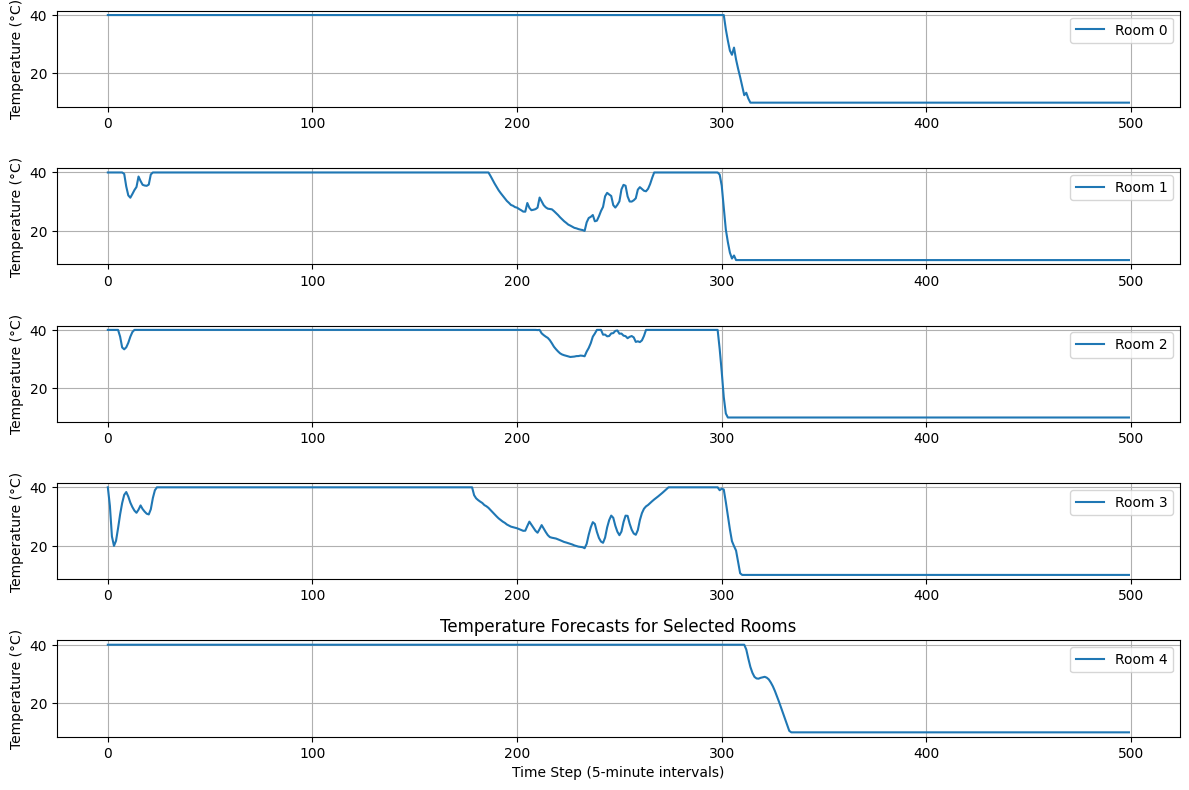


System Analysis:
System stability (max |eigenvalue|): 0.9900
System is stable
Thermal coupling strength: 0.0545
Thermal persistence: 0.3716
Average input influence: 0.0364
Learning simple dynamics from 8640 timesteps...
Persistence coefficient: 0.980
Input coefficients shape: (123, 1078)
Starting simple forecast for 2015 steps...
Forecasting step 0/2015
Forecasting step 500/2015
Forecasting step 1000/2015
Forecasting step 1500/2015
Forecasting step 2000/2015
Simple forecast completed.
Temperature range: [10.00, 40.00]


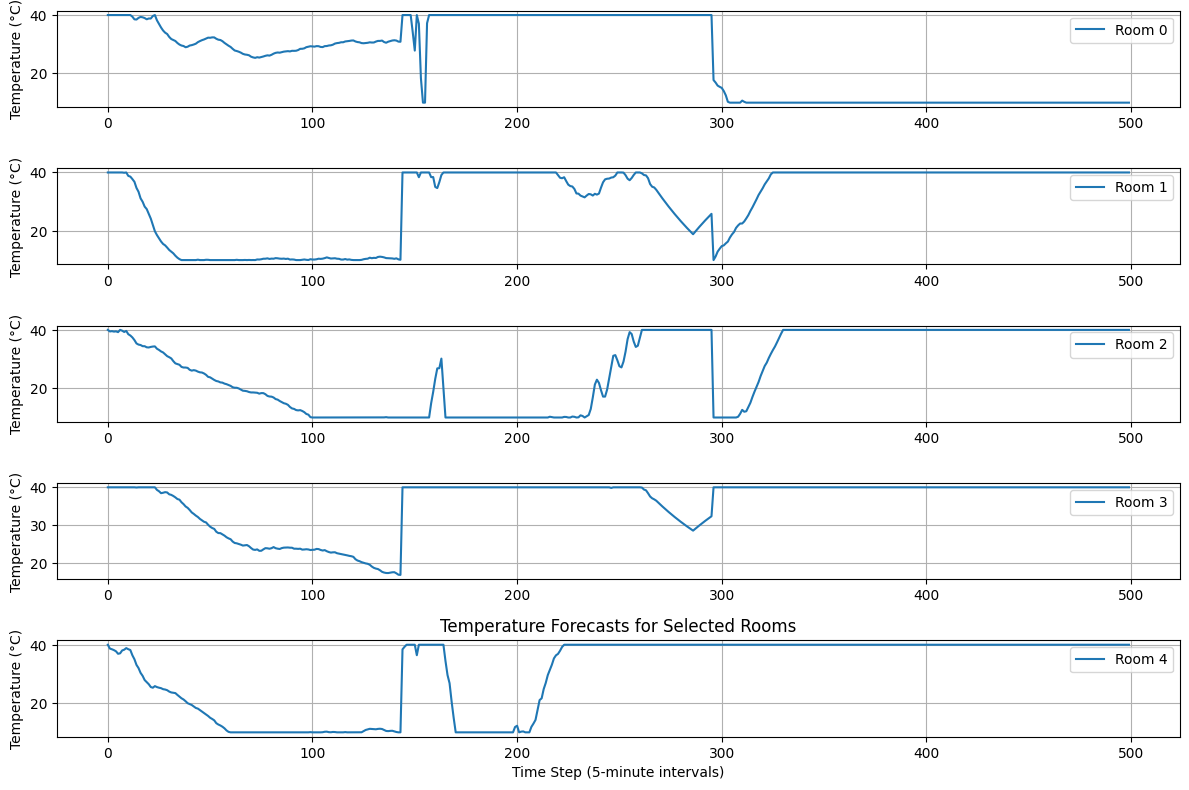

In [ ]:
forecasts_kf, trained_kf = run_building_forecasting()
plot_forecasts(forecasts_kf)
analyze_system_matrices(trained_kf)
    
forecasts_simple, predictor = run_simple_forecasting()
plot_forecasts(forecasts_simple)

    # print("Kalman Filter implementation ready!")
    # print("To use with your data, ensure the following variables are available:")
    # print("- train_temp: Training temperature data")
    # print("- train_exog: Training exogenous variables")
    # print("- train_actions: Training actions")
    # print("- initial_condition_tensor: Initial temperatures")
    # print("- exog_future_tensor: Future exogenous variables")
    # print("- actions_future_tensor: Future actions")

In [44]:
initial_condition_tensor = torch.tensor(initial_condition, dtype=torch.float32).unsqueeze(0)
forecast_tensor_kf = torch.tensor(forecasts_kf, dtype=torch.float32)
forecast_tensor_kf = torch.cat((initial_condition_tensor, forecast_tensor_kf))

forecast_tensor_simple = torch.tensor(forecasts_simple, dtype=torch.float32)
forecast_tensor_simple = torch.cat((initial_condition_tensor, forecast_tensor_simple))

ground_truth_tensor = torch.tensor(temp_data[:2016], dtype=torch.float32)  # [2016, 123]

print(forecast_tensor_kf.shape)
print(forecast_tensor_simple.shape)
print(ground_truth_tensor.shape)

def compute_mae(preds, targets):
    return torch.mean(torch.abs(preds - targets))

mae_kf = compute_mae(forecast_tensor_kf, ground_truth_tensor)
mae_simple = compute_mae(forecast_tensor_simple, ground_truth_tensor)
print(f"MAE Kalman Filter: {mae_kf}")
print(f"MAE Simple: {mae_simple}")


torch.Size([2016, 123])
torch.Size([2016, 123])
torch.Size([2016, 123])
MAE Kalman Filter: 52.19792938232422
MAE Simple: 44.6375617980957
